# Challenge 1 - Energy Production Data Simulation

## challenge summary
There are the energy production data for 500 houses. For each house, there are monthly data from July, 2011 to June, 2013. The data are given temperature data and daylight data.

Please make a model for predicting EnergyProduction using data from July 2011 to May 2013. On that basis, predict **EnergyProduction on June 2013** for each house, and calculate MAPE(Mean Absolute Percentage Error).

##1. Exploration of data
At first, we have surveyed train and test data for confirming summary and whether missing-value exists.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as pylab
import matplotlib.pyplot as plot
import seaborn as sns
from math import log
import statsmodels.api

In [2]:
data = pd.read_csv(open('./data/dataset_500.csv'))
data_train = pd.read_csv(open('./data/training_dataset_500.csv'))
data_test  = pd.read_csv(open('./data/test_dataset_500.csv'))
ymd=pd.date_range('7/1/2011', '5/1/2013', freq='MS')

In [3]:
data_train.describe()

,ID,Label,House,Year,Month,Temperature,Daylight,EnergyProduction
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,5999.000000,11.000000,250.500000,2011.956522,6.521739,14.372348,189.121870,612.748870
std,3464.251661,6.633538,144.343555,0.690226,3.524843,8.490811,29.432125,142.006144
min,0.000000,0.000000,1.000000,2011.000000,1.000000,0.800000,133.700000,254.000000
25%,2999.500000,5.000000,125.750000,2011.000000,3.000000,5.300000,169.100000,509.000000
50%,5999.000000,11.000000,250.500000,2012.000000,7.000000,13.200000,181.800000,592.000000
75%,8998.500000,17.000000,375.250000,2012.000000,10.000000,22.800000,205.200000,698.000000
max,11998.000000,22.000000,500.000000,2013.000000,12.000000,29.000000,271.300000,1254.000000


In [4]:
data_test.describe()

,ID,Label,House,Year,Month,Temperature,Daylight,EnergyProduction
count,500.000000,500,500.000000,500,500,500.00000,500.000000,500.000000
mean,6011.000000,23,250.500000,2013,6,21.70540,125.111400,586.774000
std,3467.563986,0,144.481833,0,0,0.86661,1.595726,100.292653
min,23.000000,23,1.000000,2013,6,19.30000,121.800000,451.000000
25%,3017.000000,23,125.750000,2013,6,21.10000,123.900000,518.000000
50%,6011.000000,23,250.500000,2013,6,21.90000,125.200000,565.000000
75%,9005.000000,23,375.250000,2013,6,22.50000,126.000000,668.000000
max,11999.000000,23,500.000000,2013,6,22.80000,129.100000,886.000000


In [5]:
def make_df_each_house(variable):
    df = data_train.ix[data_train.House == 1,[variable]]
    for i in range(2,501):
        tmp = data_train.ix[data_train.House == i,[variable]]
        tmp.index = range(23)
        df = pd.concat([df,tmp],axis=1)
    df.columns = range(1,501)
    df.index = ymd
    return df.sort(axis=1)
ep_df = make_df_each_house('EnergyProduction')
tm_df = make_df_each_house('Temperature')
dl_df = make_df_each_house('Daylight')

Following heat map shows the sorted Energy Data Production in order by '7/1/2011', it is observed that the same color blocks exist and it seems that the house has the same data series.


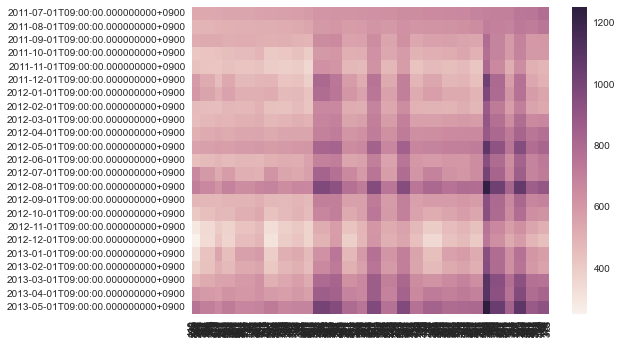

In [6]:
null=sns.heatmap(ep_df.T.sort('7/1/2011').T)

When the values of series EnergyProduction data of the houses matches with each other,  
we investigate Temperature and Daylight to check whether they also match.

We regard the houses which have common the series as a group.

Then, I pick up the group which matched in both train and test group.

In [7]:
def check_data(data):
    test_houses = dict()
    uniq_houses = dict()
    for house in range(1,501):
        ep = tuple(data.ix[data.House==house]['EnergyProduction'])
        tm = tuple(data.ix[data.House==house]['EnergyProduction'])
        dl = tuple(data.ix[data.House==house]['EnergyProduction'])

        if ep not in uniq_houses:
            uniq_houses[ep] = (tm,dl)
            test_houses[ep] = [house]
        else:
            if uniq_houses[ep][0] != tm or uniq_houses[ep][1] != dl:
                return None
            else:
                test_houses[ep].append(house)
    return test_houses.values()

train_groups = check_data(data_train)
test_groups = check_data(data_test)
print("check in train set\t:\t",('True' if train_groups is not None else 'False') )
print("check in test set\t:\t",('True' if test_groups is not None else 'False' ))
print('test group houses correspond with train group houses ?\t:\t',sorted(list(test_groups)) == sorted(list(train_groups)))

check in train set	:	 True
check in test set	:	 True
test group houses correspond with train group houses ?	:	 True


It was found the following points:

*  When the Energy Production matched, other attributes were also matched
*  Each set had common group

If we used this duplicate data, the result would depend on the number of the duplicates.
That will cause low accuracy because each group has the different number of the duplicates, according to the heatmap.

From the above, we use the house data which is picked up from each group one by one to analyze.


##2. Data Analysis
Following table and graph are a covariance matrix of the variables and scatter-plot matrix.  
They show there is positive correlation between Energy Production and Daylight and no correlation between Daylight and Temperature.


In [8]:
uniq_houses = [group[0] for group in train_groups]
u_data_train = data_train.query('House in %s'%uniq_houses).reset_index()

,Temperature,Daylight,EnergyProduction
Temperature,1.000000,-0.055286,0.258481
Daylight,-0.055286,1.000000,0.519554
EnergyProduction,0.258481,0.519554,1.000000


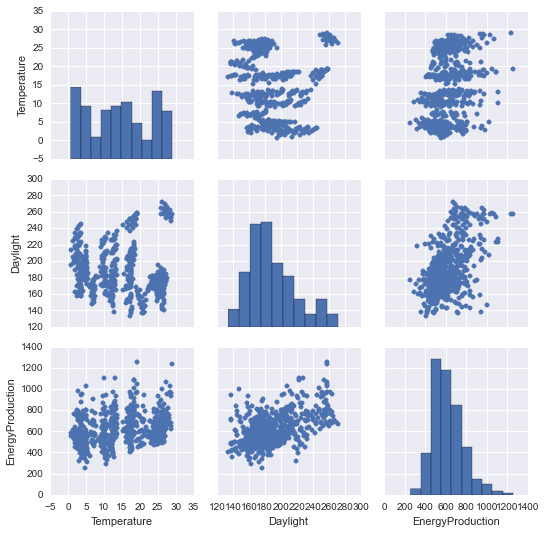

In [9]:
null = sns.pairplot(u_data_train[['Temperature','Daylight','EnergyProduction']])
pd.DataFrame(np.corrcoef(u_data_train[['Temperature','Daylight','EnergyProduction']].T),columns=['Temperature','Daylight','EnergyProduction'],index=['Temperature','Daylight','EnergyProduction'])

According to the above graph and table, we can perform a regression analysis by using Daylight and Temperature as independent variables.  
Multiple regression analysis can be performed only when there is no serial correlation.
Because the data is of time series, the result of the regression should be spurious.

Plotting attributes of each house, they obviously have a periodic and trend.


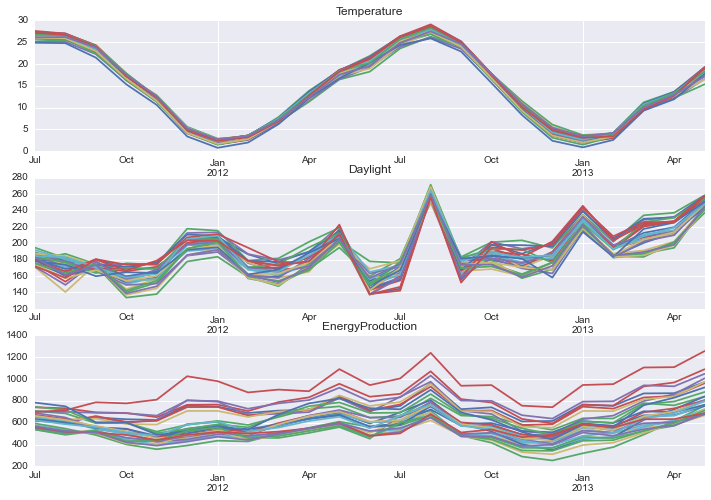

In [10]:
fig, axes = plot.subplots(ncols=1,nrows=3, figsize=(30,5))
axes[0].set_title('Temperature')
axes[1].set_title('Daylight')
axes[2].set_title('EnergyProduction')
null = tm_df[uniq_houses].plot(figsize=(12, 8),legend=False, ax=axes[0])
null = dl_df[uniq_houses].plot(figsize=(12, 8),legend=False, ax=axes[1])
null = ep_df[uniq_houses].plot(figsize=(12, 8),legend=False, ax=axes[2])

In time series analysis, we have to test whether data has stationarity.  
Hence, we carry out the augmented Dickey-Fuller test under the null hypothesis where there is a unit root.

Following graphs show p-values of each attributes data of each house.

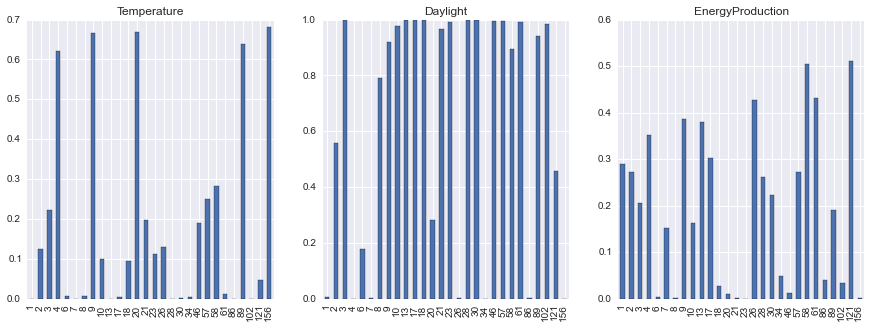

In [11]:
uniq = lambda df:df[uniq_houses].sort(axis=1)
fig, axes = plot.subplots(ncols=3, figsize=(15,5))
axes[0].set_title('Temperature')
axes[1].set_title('Daylight')
axes[2].set_title('EnergyProduction')
null = uniq(tm_df).apply(lambda x:statsmodels.api.tsa.adfuller(x, autolag = 'AIC')[1]).plot(kind ='bar', ax=axes[0])
null = uniq(dl_df).apply(lambda x:statsmodels.api.tsa.adfuller(x, autolag = 'AIC')[1]).plot(kind ='bar', ax=axes[1])
null = uniq(ep_df).apply(lambda x:statsmodels.api.tsa.adfuller(x, autolag = 'AIC')[1]).plot(kind ='bar', ax=axes[2])

From above, we employ the one-difference of time series data because we can not reject the null hypothesis.  

## 3.Prediction

We employ the p-lag Vector autoregression model by making a vector including Temperature, Daylight and EnergyProduction.  
We use Akaike Information Criterion to determine the value of p-lag from 0 to max 4.

In addition, the best fitted exogenous variable set which imporves absolute percentage error is selected from trend and constant term , only constant , common constant.

In [12]:
from statsmodels.tsa.api import VAR

def predict(house,lag,trend):
    df = data_train.query('House == %d' % house)[['Temperature','Daylight','EnergyProduction']].set_index(ymd)
    model = VAR(df.diff().dropna())
    results = model.fit(trend=trend,maxlags=lag,ic='aic')
    lag_order = results.k_ar
    tm,dl,ep = (results.forecast(df.diff().values[-lag_order:],1) + np.array(df.ix['5/1/2013']))[0]
    return ep

apes = []
mape = 0
for house in uniq_houses:
    y = data_test.EnergyProduction[house-1]
    ape = 1.0
    for trend in ['c','nc','ct']:
        ape = min(ape,abs(predict(house,4,trend) - y)/y)
    apes.append(ape)

Mean Absolute Percentage Error(uniq houses) : 0.0880397245895


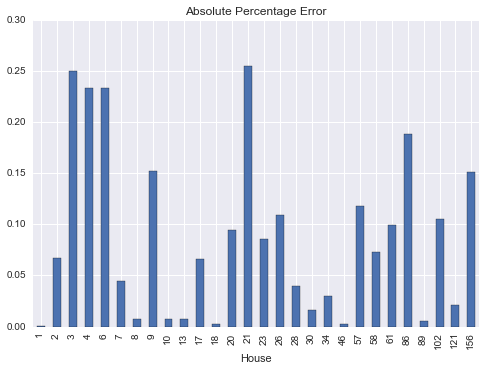

In [13]:
ax=pd.DataFrame(apes,index=uniq_houses).sort().plot(kind='bar',legend=False,title = 'Absolute Percentage Error')
ax.set_xlabel('House')
print('Mean Absolute Percentage Error(uniq houses) :',sum(apes)/len(apes))

# Result & Conclution:

In [14]:
with open('predicted_energy_production.csv','w') as output_file:
    mape=0
    output_file.write('House, EnergyProduction\n')
    for house in range(1,501):
        y = data_test.EnergyProduction[house-1]
        ape = (1.0,0)
        for trend in ['c','nc','ct']:
            predicted = predict(house,4,trend)
            ape = min(ape,(abs(predicted- y)/y,predicted), key = lambda x:x[0])
        output_file.write('{0},{1},{2}\n'.format(house, ape[1],y))
        mape += ape[0]
    print("MAPE (500 houses) : %.3f%%" % ((mape/500)*100))

with open('mape.txt','w') as mape_file:
    mape_file.write('MAPE : %f' % (mape/500))

MAPE (500 houses) : 8.694%


According to the result of this regression analysis, we've got a MAPE of 8.694%.  
In this analysis, we did not deal with seasonal trend although they exsist obviously.  
This is because typical technic for removing the trend is to use 12 month moving average which needs at least 3 years data.

We might obtain more better result when seasonal trend can be removed.